# Project 3: Natural Language Processing 
## Authors (Group L2): 
Mariusz Oskar Kurek maku@itu.dk, Julia Trzandel jtrz@itu.dk, Janusz Jakub Wilczek jawi@itu.dk, Lini Zhang linz@itu.dk 
### Submission: 03.06.2022 / Last Modified: NA
#### Aim:
This notebook contains the step-by-step process of building a natural language machine learning model to automatically detect (a) Offensive language and (b) Sentiment.
#### Data:
The initial data was obtained from the TweetEval GitHub repository, that provides data for supervised training of classifiers for natural language processing. More specifically, it provides prepared data for several mini-projects involving the analysis of different characteristics of tweets.

## Imports

In [1]:
import regex as re # we use regex to process emojis
import numpy as np
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline 

from nltk.corpus import stopwords 
from nltk import download # required to download some nltk content
download('punkt') # required to run some nltk functions
download('stopwords') # required to run some nltk functions
from nltk.tokenize import TweetTokenizer, sent_tokenize # tokenisation functions
from nltk.lm.preprocessing import padded_everygram_pipeline # to create n-grams
from nltk.lm import MLE, KneserNeyInterpolated # for perplexity calculations
from nltk.metrics.agreement import AnnotationTask # to calculate inter-anotator agreement

from sklearn.utils import resample # function for upsampling
from sklearn.linear_model import SGDClassifier # Machine learning classifier 
from imblearn.pipeline import Pipeline # pipeline function
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer # functions to extract features from tweets
from imblearn.over_sampling import SMOTE # Synthetic Minority Oversampling Technique
from sklearn.model_selection import GridSearchCV, KFold # functions to automate finding mest parameters for automatic annotation

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Janusz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Janusz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Defining functions 

Our tokenizer 'tokenize' is based upon the demo code provided by the lecturer. However, we have made significant changes to it:
- We remove stop words
- We do not use unmatchable list of tokens
- We consider emojis as tokens
- We do not seperate hashtags from a hash sign

In [2]:
def tokenize(text):
    
    # Initialise list
    tokens = []

    # Compile patterns for speedup
    token_pat = re.compile(r'[\w|#]+|\p{Emoji}+') # parts of words and emojis
    skippable_pat = re.compile(r'\s+')  # typically spaces

    for line in text.splitlines():
        line = line.casefold()
        
        while line:
            # Try finding a skippable token delimiter first.
            skippable_match = re.search(skippable_pat, line)
            if skippable_match and skippable_match.start() == 0:
                # If there is one at the beginning of the line, just skip it.
                line = line[skippable_match.end():]
            else:
                # Else try finding a real token.
                token_match = re.search(token_pat, line)
                if token_match and token_match.start() == 0: # If there is one at the beginning of the line, tokenize it.
                    if line[:token_match.end()] != 'user' and line[:token_match.end()] not in stop_words : # skipping censored Twitter handles and stopwords
                        tokens.append(line[:token_match.end()])
                    line = line[token_match.end():]
                    
                else:
                    # Else there is unmatchable material here.
                    # It ends where a skippable or token match starts, or at the end of the line.
                    unmatchable_end = len(line)
                    if skippable_match:
                        unmatchable_end = skippable_match.start()
                    if token_match:
                        unmatchable_end = min(unmatchable_end, token_match.start())
                    # Add it to unmatchable and discard from line.
                    line = line[unmatchable_end:]

    return tokens

`freq_plot` makes 3 plots of our tokens:
- Cumulative frequency by index
- Cumulative frequency by index, top 10000 tokens
- Log-log plot for Zipf's law

In [3]:
def freq_plot(tokens, voc, idx):
    frq = pd.DataFrame(voc.most_common(), columns=['token', 'frequency'])

    # Index in the sorted list
    frq['idx'] = frq.index + 1

    # Frequency normalised by corpus size
    frq['norm_freq'] = frq.frequency / len(tokens)

    # Cumulative normalised frequency
    frq['cumul_frq'] = frq.norm_freq.cumsum()
    
    xlabel = 'Rank'
    ylabel = 'Cumulative frequency'
    
    fig, axs = plt.subplots(1, 3, figsize=(13, 7))
    
    fig.suptitle(idx) 
    
    # Plot: Cumulative frequency by index
    axs[0].scatter(x='idx', y='cumul_frq', data=frq)
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)

    # Plot: Bar plot
    max_x = 10000
    axs[1].bar(frq['idx'][:max_x], frq['frequency'][:max_x], width=5)
    #if len(frq) < max_x:
    #    axs[1].set_xlim(round(-79 * len(frq) / max_x), len(frq))
   # else:
    #    axs[1].set_xlim(-79, 10000)
    axs[1].set_xlabel("word")
    axs[1].set_ylabel("frequency")
    

    # Plot: Log-log plot for Zipf's law
    
    frq['log_frq'] = np.log(frq.frequency)
    frq['log_rank'] = np.log(frq.frequency.rank(ascending=False))
    
    max_p, min_p = max(frq['log_frq']),min(frq['log_frq'])
    xs = np.arange(min_p,max_p,0.1)
    
    axs[2].scatter(x='log_rank', y='log_frq', data=frq)
    axs[2].plot([min_p, max_p], [max_p, min_p], c='red')
    axs[2].set_xlabel('log(rank)')
    axs[2].set_ylabel('log(frequency)')
    
    plt.tight_layout()
    

`read_text` creates a list of tokenized tweets or loads them from a file if possible.

In [4]:
def read_text(path: str, dataset:str):
    try:
        return pickle.load(open(f'../data/processed/{dataset}_{path}_tokens.dat', 'rb'))
    except:
        text = [tokenize(tweet) for tweet in open(f'../data/{dataset}/{path}_text.txt', 'r', encoding='utf-8').read().splitlines()]
        pickle.dump(text, open(f'../data/processed/{dataset}_{path}_tokens.dat', 'wb'))
        return text

`create_df` creates a pandas dataframe of our tokens and a respective label

In [5]:
def create_df(path:str, dataset:str):
    tweets = read_text(path, dataset)
    labels = list(map(int, open(f'../data/{dataset}/{path}_labels.txt', 'r', encoding='utf-8').read().splitlines()))
    df = pd.DataFrame(labels,columns =['label'])    
    
    for i in range(len(tweets)):
        tweets[i] = ' '.join(tweets[i]) # concatenate the list of tokens into a string 
    
    df['tweet'] = tweets
    
    return(df)

## Global variables

In [6]:
stop_words = set(stopwords.words('english'))
keys = ['offensive', 'sentiment', 'gatsby']

## Tokenizers comparison

Before we can train any machine learning (ML) model to annotate data, we first need to analyze our data and extract features from it. The structure of tweets is as follows:
- each tweet consist of sentences 
- each sentence consists of words

Some basic ML algorithms can't take strings as input, like sentences. Therefore, we need to transform our data into a form recognisable by ML algorithms. It has become customary in natural language processing (NLP) to name words as tokens, which nomenclature we use later on. At some point we need to convert our strings into numbers. However, we do it later in the notebook and firstly we compare two tokenization methods. 

We have chosen two tokenization implementations for this study, one from NLTK package and one provided to us by Associate Professor at IT-University of Copenhagen Christian Hardmeier chrha@itu.dk. Nonehteless, we edited the provided code to hopefully improve its performance. 

In [7]:
tk = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True) # initaiate tokenizer object

To compare the tokenizers, we create dictionaries, for which keys are names of datasets, and their respective values are tuples, where at index 0 are reults from NLTK tokenizer, and at index 1 results from our implementation. Dictionary "tokens" consists of tokenized tweets, whehreas "counters" is a bag of words, e.i. sum of occurances for each token. 

In [8]:
tokens = dict()
counters = dict() 

for key in keys:
    
    if key == 'gatsby':
        # The Great Gatsby has a different path, also we remove Gutenberg's header and footer
        text = open('../data/GreatGatsby.txt', 'r', encoding='utf-8').read().split('***')[2]
    else:
        text = open(f'../data/{key}/train_text.txt', 'r', encoding='utf-8').read()
        
    tokens[key] = (tokenize(text), tk.tokenize(text))
    counters[key] = (Counter(tokens[key][0]), Counter(tokens[key][1]))

    # Code below prints the key statistics about tokenizers' output in each dataset 
    
    print(key.capitalize())
    print('-' * len(key))
    
    length = len(tokens[key][0])
    length_counter = len(counters[key][0])
    print(f"""Our tokenizer found {length} tokens, {length_counter} of which\
 (or {round(100 * length_counter / length, 2)}%) are unique.""")
    
    length = len(tokens[key][1])
    length_counter = len(counters[key][1])
    print(f"""TweetTokenizer found {length} tokens, {length_counter} of which\
 (or {round(100 * length_counter / length, 2)}%) are unique.\n""")

Offensive
---------
Our tokenizer found 125030 tokens, 19135 of which (or 15.3%) are unique.
TweetTokenizer found 271264 tokens, 19736 of which (or 7.28%) are unique.

Sentiment
---------
Our tokenizer found 537228 tokens, 45314 of which (or 8.43%) are unique.
TweetTokenizer found 1015580 tokens, 49124 of which (or 4.84%) are unique.

Gatsby
------
Our tokenizer found 23634 tokens, 5694 of which (or 24.09%) are unique.
TweetTokenizer found 61266 tokens, 5936 of which (or 9.69%) are unique.



We observe that our tokenizer creates less and more unique tokens than NLTK method, across all datasets. However, it follows our expectations since our tokenizer removes stopwords, which NLTK does not. We can see it in the statistics below.

In [9]:
print('20 most common words\n')
for key in keys:
    print(f'{key.capitalize()} our tokenizer:')
    for rank, word in enumerate(counters[key][0].most_common(20), 1):
        print(f'{rank: >2}. {word[0]} - {word[1]} occurences')
    print()    
    
    print(f'{key.capitalize()} NLTK lib. tokenizer:')
    for rank, word in enumerate(counters[key][1].most_common(20), 1):
        print(f'{rank: >2}. {word[0]} - {word[1]} occurences')    
    print()

20 most common words

Offensive our tokenizer:
 1. liberals - 1245 occurences
 2. gun - 1244 occurences
 3. control - 1106 occurences
 4. like - 1005 occurences
 5. antifa - 1004 occurences
 6. people - 834 occurences
 7. conservatives - 776 occurences
 8. #maga - 737 occurences
 9. amp - 615 occurences
10. get - 589 occurences
11. one - 574 occurences
12. know - 563 occurences
13. trump - 533 occurences
14. think - 487 occurences
15. would - 472 occurences
16. right - 444 occurences
17. good - 419 occurences
18. time - 353 occurences
19. us - 349 occurences
20. go - 349 occurences

Offensive NLTK lib. tokenizer:
 1. . - 12805 occurences
 2. the - 8128 occurences
 3. is - 5859 occurences
 4. to - 5587 occurences
 5. a - 4840 occurences
 6. you - 4738 occurences
 7. and - 4600 occurences
 8. ! - 4332 occurences
 9. " - 4238 occurences
10. of - 3441 occurences
11. are - 3235 occurences
12. i - 3034 occurences
13. he - 2646 occurences
14. ? - 2638 occurences
15. that - 2534 occurences
16.

One of the most popular tokens generated by NLTK, are:
-the 
-a
-.
-!
We believe that such tokens are valueless in our case since they do not help detect either sentiment or offensive language. In case of offensive language, we think that swear words or invectivesa are determinators of offence.

It must be noted, that our tokeniser generated gibbrish tokens, such as "u002c", which is a unicode representation of comma. Nonehteless, if we look into our data, we can see that it contains such errors. Thus, the cause is not in our implementation, but the data itself is corrupted.  

## Zipf's law

According to Brittanica encyclopedia [1], zip's law defines a property in English language that frequency of any words is inversly propotional to its rank in the frequency table:

$$F(r) = \frac{0.1}{r} $$

where r is a rank of the word. 

It means that, the most common word appears about 10% of the time in any text, where as second most common word appears about 5%, third around 2.5% and so on. 

Given that property, we should observe zipf's law in our data. To investigate that, we make a cummulative plot, bar plot and log-log plot with a zipf's law line. 

[1] - https://www.britannica.com/topic/Zipfs-law

Plots for our tokenizer:

<ipython-input-3-73f2482f306d>:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


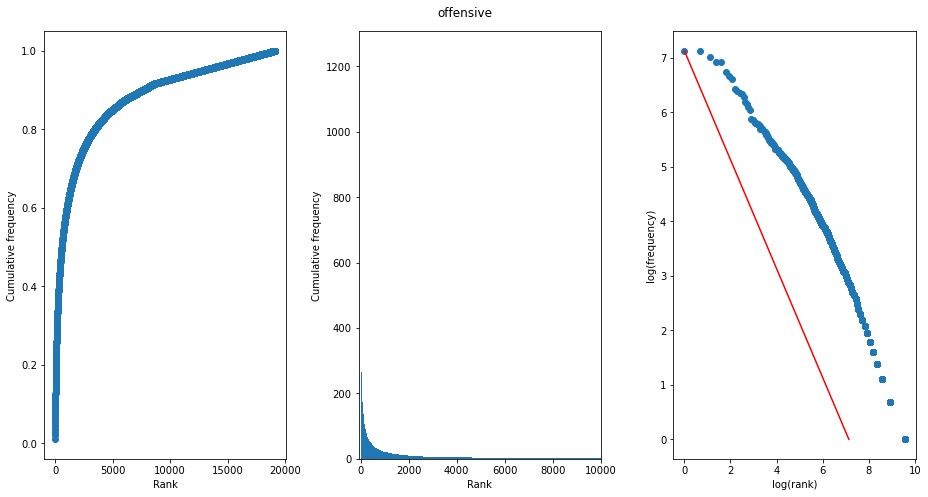

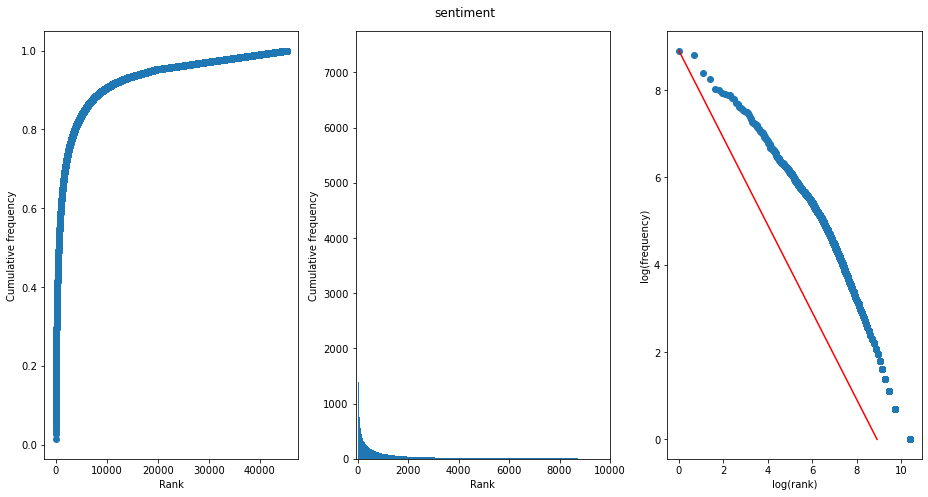

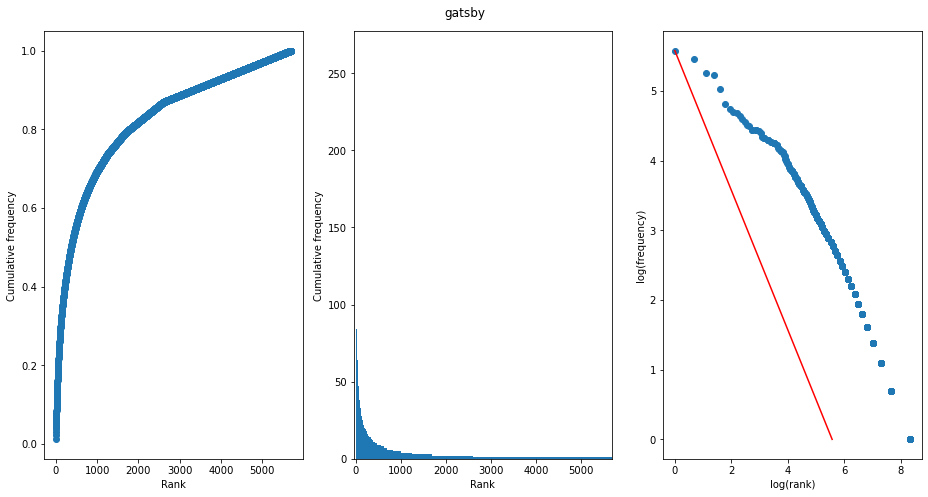

In [10]:
for key in keys:
    freq_plot(tokens[key][0], counters[key][0],key)

Plots for NLTK tokenizer:

<ipython-input-3-73f2482f306d>:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


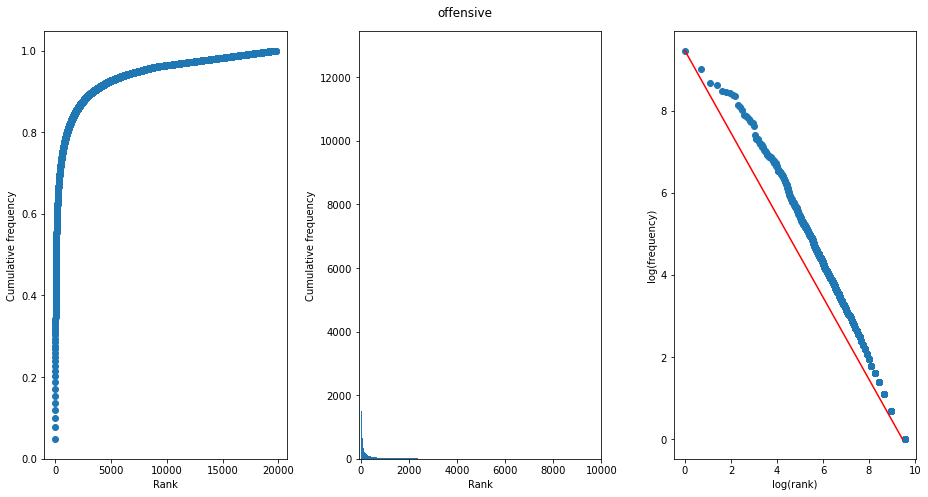

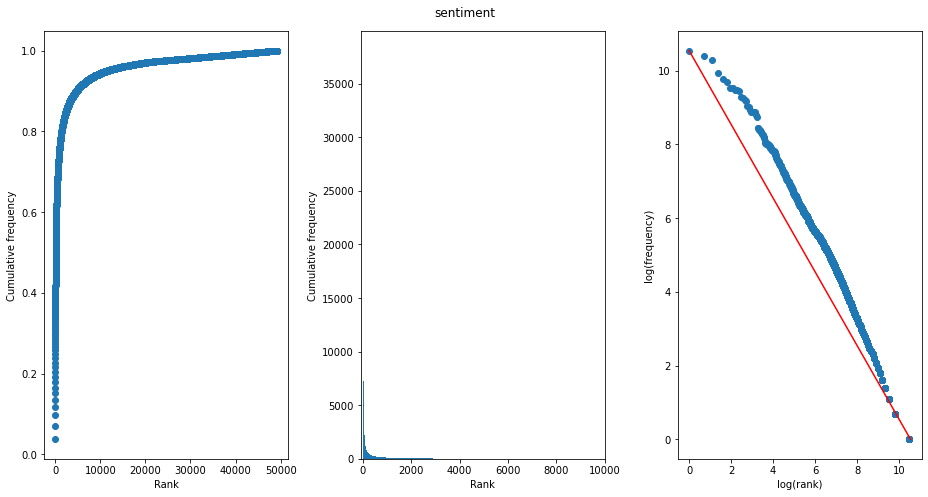

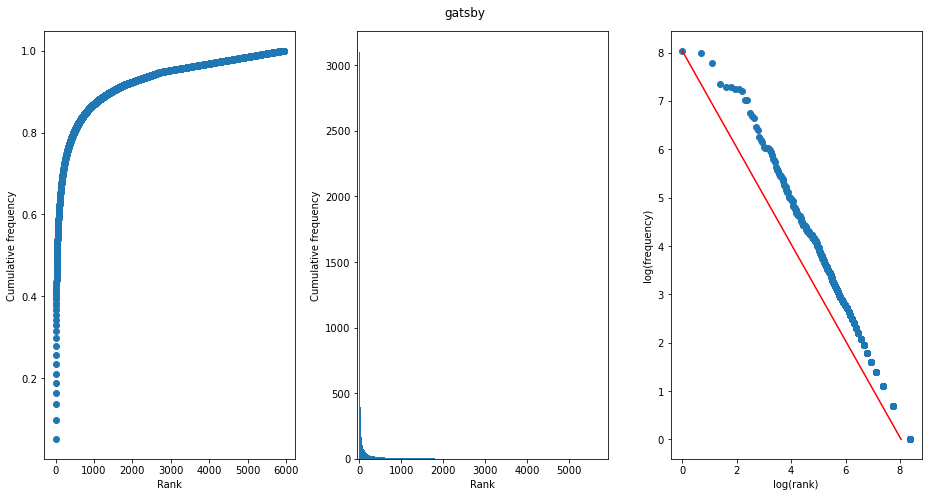

In [11]:
for key in keys:
    freq_plot(tokens[key][1], counters[key][1],key)

In [12]:
# drop gatsby since we won't use it anymore
try:
    counters.pop('gatsby')
    tokens.pop('gatsby')
    keys.remove('gatsby')
except KeyError:
    pass
except ValueError:
    pass


## Further data investigation 

We drop tokens from NLTK since we belive our tokenzier generates better output. 

In [13]:
# droping tweet tokenizer results at index 1 
for key in keys:
    if type(tokens[key]) == tuple:
        tokens[key] = tokens[key][0]
        
    if type(counters[key]) == tuple:
        counters[key] = counters[key][0]

We compare the most frequent tokens with a fueqency dictionary list for English

In [14]:
wordfre = pd.read_excel(r'../data/wordFrequency.xlsx', sheet_name='1 lemmas')
fre_words = pd.DataFrame(wordfre, columns= ['lemma'])
print("Most frequent words in general word list for English:")
print(fre_words.head(20))
print()

for key in keys:
    print(f'{key.capitalize()}:')
    for rank, word in enumerate(counters[key].most_common(20)):
        print(f'{rank: <2}  {word[0]}')
    print()

Most frequent words in general word list for English:
   lemma
0    the
1     be
2    and
3      a
4     of
5     to
6     in
7      i
8    you
9     it
10  have
11    to
12  that
13   for
14    do
15    he
16  with
17    on
18  this
19   n't

Offensive:
0   liberals
1   gun
2   control
3   like
4   antifa
5   people
6   conservatives
7   #maga
8   amp
9   get
10  one
11  know
12  trump
13  think
14  would
15  right
16  good
17  time
18  us
19  go

Sentiment:
0   tomorrow
1   may
2   u002c
3   day
4   going
5   night
6   see
7   friday
8   sunday
9   1st
10  like
11  time
12  get
13  saturday
14  amp
15  go
16  one
17  2nd
18  new
19  u2019s



Our most frequent tokens are different from most common words in English language. Nonetheless, it is what we expected since we remove stopwords from tokens.

We look at the least frequent tokens to test if our tokenizer generates some outliers or unexpected tokens.

In [15]:
for key in keys:
    print(f'{key.capitalize()}:')
    c = 0
    for token in counters[key].keys():
        if counters[key][token] < 4 and c < 20:
            print(f'{token}\t{counters[key][token]}')
            c+=1
    print()

Offensive:
countrymen	1
eight	3
denied	3
breitbarters	1
progressing	1
reads	1
fiona	3
parody	2
unto	1
heat	3
optic	1
optics	2
substance	2
vetsresistsquadron	1
scout	1
lifetimes	1
undone	2
obummer	1
specifics	2
plethora	1

Sentiment:
qt	3
hogwarts	2
#happybirthdayremuslupin	1
#sj	2
headley	1
alciato	1
invest	3
louboutins	1
willam	1
cred	1
hmw	1
#hotwife	1
20yr	1
zuoma	1
creighton	3
sexist	1
foxx	1
uneasyness	1
patiently	3
bd1	1



We do not see errors or counterintuitie tokens apart from some, which can be attributed to grammatical errors and own creativity of Tweeter's users, like for instance "uneasyness" or "breitbarters"

## N-grams generation

In [16]:
bigrams = list(zip(tokens["offensive"], tokens["offensive"][1:]))
Counter(bigrams).most_common(20)

[(('gun', 'control'), 1031),
 (('control', 'laws'), 102),
 (('❤', '️'), 72),
 (('looks', 'like'), 61),
 (('president', 'trump'), 49),
 (('\u200d', '♂'), 46),
 (('common', 'sense'), 45),
 (('♂', '️'), 44),
 (('trump', 'supporters'), 43),
 (('#maga', '#kag'), 43),
 (('like', 'antifa'), 36),
 (('years', 'ago'), 36),
 (('\u200d', '♀'), 34),
 (('#tcot', '#maga'), 34),
 (('️', '❤'), 34),
 (('year', 'old'), 33),
 (('♀', '️'), 33),
 (('#maga', '#rednationrising'), 33),
 (('gun', 'violence'), 32),
 (('go', 'back'), 29)]

In [17]:
trigrams = list(zip(tokens["offensive"], tokens["offensive"][1:], tokens["offensive"][2:]))
Counter(trigrams).most_common(20)

[(('gun', 'control', 'laws'), 102),
 (('\u200d', '♂', '️'), 44),
 (('️', '❤', '️'), 34),
 (('\u200d', '♀', '️'), 33),
 (('#tcot', '#maga', '#rednationrising'), 33),
 (('❤', '️', '❤'), 26),
 (('common', 'sense', 'gun'), 26),
 (('sense', 'gun', 'control'), 26),
 (('need', 'gun', 'control'), 25),
 (('sensible', 'gun', 'control'), 24),
 (('strict', 'gun', 'control'), 24),
 (('️', '🇺🇸❤', '️'), 23),
 (('🇺🇸❤', '️', '🇺🇸❤'), 21),
 (('support', 'gun', 'control'), 18),
 (('gun', 'control', 'works'), 16),
 (('like', 'gun', 'control'), 15),
 (('want', 'gun', 'control'), 15),
 (('gun', 'control', 'would'), 13),
 (('law', 'abiding', 'citizens'), 13),
 (('strictest', 'gun', 'control'), 13)]

In [18]:
quadgrams = list(zip(tokens["offensive"], tokens["offensive"][1:], tokens["offensive"][2:], tokens["offensive"][3:]))
Counter(quadgrams).most_common(20)

[(('❤', '️', '❤', '️'), 26),
 (('common', 'sense', 'gun', 'control'), 25),
 (('🇺🇸❤', '️', '🇺🇸❤', '️'), 21),
 (('️', '🇺🇸❤', '️', '🇺🇸❤'), 19),
 (('️', '❤', '️', '❤'), 17),
 (('strict', 'gun', 'control', 'laws'), 11),
 (('nra', 'calls', 'gun', 'control'), 10),
 (('calls', 'gun', 'control', 'research'), 10),
 (('gun', 'control', 'research', 'unethical'), 10),
 (('#tories', '#labour', '#ge2017', '#conservatives'), 9),
 (('#labour', '#ge2017', '#conservatives', 'conservatives'), 9),
 (('🤦🏾', '\u200d', '♂', '️'), 9),
 (('🤷', '\u200d', '♂', '️'), 9),
 (('nra', 'blames', 'gun', 'control'), 8),
 (('blames', 'gun', 'control', 'laws'), 8),
 (('kkk', 'hoods', 'beating', 'strangers'), 7),
 (('antifa', 'kkk', 'hoods', 'beating'), 6),
 (('hoods', 'beating', 'strangers', 'know'), 6),
 (('beating', 'strangers', 'know', 'nothing'), 6),
 (('\u200d', '♂', '️', '🤦🏾'), 5)]

In [19]:
# We don't use the above for anything
del(bigrams)
del(trigrams)
del(quadgrams)

In [20]:
#reading tweets and division into sentences of tokens
tweets = list()
text = open('../data/offensive/train_text.txt', 'r', encoding='utf-8').read().splitlines()
for line in text: # divide tweets
    tweets.append(sent_tokenize(line)) # add sentences to tweet list
    for i in range(len(tweets[-1])): # tokenize sentences in the tweet 
        tweets[-1][i] = tokenize(tweets[-1][i])        

In [21]:
tweets[0]

[['bono', 'cares'],
 ['soon',
  'people',
  'understand',
  'gain',
  'nothing',
  'following',
  'phony',
  'celebrity'],
 ['become',
  'leader',
  'people',
  'instead',
  'help',
  'support',
  'fellow',
  'countrymen']]

In [22]:
tweets[6]

[['looking', 'like', 'plant', '#maga', '#walkaway']]

## Max. likelihood evaluation classifier  - perplexity classifier

MLE is the simplest classifier. The chance of a word appearing after a certain phrase is defined by a formula:
$$p(w_3|w_1, w_2) = \frac{count(w_1w_2w_3)}{count(w_1w_2•)} $$
The chance of the word $w_3$ appearing after two words ($w_1$, $w_2$) is the number of times this exact combination appeared before divided by the number of all trigrams starting with $w_1$ and $w_2$. This formula works similarly for other n-grams.

In [23]:
lm = [None, None]
for i in range(2, 4): 
    lm.append(MLE(i))
    train, vocab = padded_everygram_pipeline(i,[item for sublist in tweets for item in sublist])
    lm[i].fit(train, vocab)
    print(f'{i}\n---')
    print(lm[i].generate(10))

2
---
['live', 'syria', 'assad', 'much', 'fun', '</s>', 'listen', 'dana', 'may', 'lot']
3
---
['right', 'communist', 'group', 'want', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>']


In [24]:
print(lm[2].score('control', ['gun']))
print(lm[2].score('Trump', ['idiot']))

print(lm[2].logscore('control', ['gun']))
print(lm[2].logscore('Trump', ['idiot']))

0.8287781350482315
0.0
-0.2709421527624942
-inf


This model's main flaw is considering n-grams that did not appear in the training to be impossible (as we can see with bigram "idiot Trump"). On the other hand, "gun control" is the most popular bigram in this data set, so its score is high.

In [25]:
val = read_text('train', 'offensive')

In [26]:
# for i in range(2, 4): 
#     val_test, _ = padded_everygram_pipeline(i, val)
#     for n, t in enumerate(val_test):
#         if n == 10:
#             break
#         for word in t:
#             print(word)
#         print(lm[i].perplexity(t))
        
        

## KneserNeyInterpolated classifier - perplexity classifier 
$$p_{cont}(w) = \frac{\#types(•w)}{\#types(••)}$$

In [27]:
text = read_text('train', 'offensive')

In [28]:
lm = [None, None]
for i in range(2, 4):
    lm.append(KneserNeyInterpolated(i))
    train, vocab = padded_everygram_pipeline(i ,text)
    lm[i].fit(train, vocab)
    print(f'{i}\n---')
    print(lm[i].generate(10))

2
---
['sake', 'power', 'last', 'minute', 'claims', 'allegations', 'far', 'left', 'hated', '</s>']
3
---
['immaturity', 'level', 'goverment', 'party', 'disgusting', '</s>', '</s>', '</s>', '</s>', '</s>']


In [29]:
print(lm[2].score('control', ['gun']))
print(lm[2].score('Trump', ['idiot']))

print(lm[2].logscore('control', ['gun']))
print(lm[2].logscore('Trump', ['idiot']))

0.8286981860301168
4.20065612199525e-06
-0.27108133068085194
-17.86095388190444


In [30]:
val = read_text('val', 'offensive')

In [31]:
# for i in range(2, 4): # changed 7 to 4 
#     val_test, _ = padded_everygram_pipeline(i, val)
#     for n, t in enumerate(val_test):
#         print(lm[i].perplexity(t))

In [32]:
# choose some words, calculate for them perplexity in both models and compare them to each other, e.g. attempt to explain such perplexity score was achieved

##  Inter-annotator agreement
https://www.nltk.org/_modules/nltk/metrics/agreement.html

All the group members annotated 100 tweets as either offensive or not. We calculate some statistics based on our evaluations.

In [33]:
manual_labels = [x.split(' ') for x in open('../data/Manual_analysis.txt')]
a = AnnotationTask(manual_labels) # us and provided labels, all 
manual_labels = manual_labels[:-100] # delete provided labels
u = AnnotationTask(manual_labels) # only us

In [34]:
print(a.avg_Ao()) # degree of agreement Average observed agreement across all coders and items.
print(u.avg_Ao())

0.8100000000000002
0.835


In [35]:
print(a.pi()) #Scott 1955; here, multi-pi. Equivalent to K from Siegel and Castellan (1988).
print(u.pi())

0.5676394021590726
0.6125737430659504


In [36]:
print(a.kappa()) #Cohen 1960 Averages naively over kappas for each coder pair.
print(u.kappa())

0.5710652653319795
0.613489592225138


Having investigated our data and understood the theory behind annotation, we can proceed to preparing our data for ML. 

## Imbalanced data and resampling

In [37]:
off_labels = list(map(int, open('../data/offensive/train_labels.txt', 'r').read().splitlines()))
sum(off_labels) / len(off_labels) * 100

33.07317891910037

The offensive training data set, there are two times more non-offensive tweets than offensive. Thus, our data is imbalanced. For the best results, these parts should be equal. Hence, we must somehow resample our data. We present one simple method to do that. However, the upsampling method of choice for ML is Synthetic Minority Oversampling Technique (SMOTE).

One the simplest ways to upsample minority class, is to create copies of the data entries from minority class. However, it does not create the satisfactory effect, since such an approach can make ML algorithm more prone to overfitting. Thus, we use later on SMOTE, and our impelmentention has only a ilustrative purpose. 

In [38]:
def upsample(df, binary: bool):
    if binary:
        #set the minority class to a seperate dataframe
        df_minor = df[df['label'] == 1]
        #set majority class to another dataframe
        df_major = df[df['label'] != 1]  
        
        if len(df_minor) > len(df_major) :
            df_major, df_minor = df_minor, df_major
       

        #concatenate the upsampled dataframe
        df = pd.concat([resample(df_minor,random_state=42,n_samples=len(df_major),replace=True),df_major])
    

    return(df)

Head of data before upsampling:

In [39]:
df = pd.DataFrame(off_labels, columns = ['label'])
df['tweet'] = tweets
df.head(10)

,label,tweet
0,0,"[[bono, cares], [soon, people, understand, gai..."
1,1,"[[eight, years, republicans, denied, obama, pi..."
2,0,"[[get, line, help], [gonna, fine], [game, went..."
3,0,"[[great], [hi, fiona]]"
4,1,"[[become, parody, unto], [certainly, taken, he..."
5,0,"[[vetsresistsquadron, bullshit], [girl, scout,..."
6,1,"[[looking, like, plant, #maga, #walkaway]]"
7,0,"[[lol], [except, successful, president, lifeti..."
8,0,"[[willie, fan, since, born, love, holding, ral..."
9,0,"[[link, channel, plethora, topics, peruse]]"


Head of data and ratio between minority/majority class after upsampling:

In [40]:
df = upsample(df, True)
print(sum(df['label'])/len(df['label']) * 100)
df.head(10)

50.0


,label,tweet
9657,1,"[[see, boobs, lol, 😂😜😘😇]]"
10662,1,"[[bull, shit, stop, putting, words, people, mo..."
2530,1,"[[*, lives, chicago, *, thinks, gun, control, ..."
3886,1,"[[little, ass, boy, 🐒]]"
3357,1,"[[total, phony]]"
3285,1,"[[fuckin, great, brother], [laughed, like, lit..."
11432,1,"[[love, wet, liberals, frightened, us], [yet, ..."
9394,1,"[[jose, ramirez, stealing, hitting, average, h..."
4936,1,"[[#ijustdontseemyself, ever, supporting, stric..."
6496,1,"[[hplyk, fuck]]"


## Automatic labeling with ML
https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html

We decided to use two classes to hasten our classifiers' evaluatation proccess. Firstly, we create a pipeline, whose purpose is to automate feature extraction and classifier training. There are four steps in the Pipeline:
1. CountVectorizer: 
    1. CountVectorizer object converts our tokens into numerical values, which can be processed by ML, and creates n-grams.
2. SMOTE
    1. SMOTE is an upsampling method of choice
3. TfidfTransformer
    1. "Transform a count matrix to a normalized tf or tf-idf representation. Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification. The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus. " [2]
4. SGDClassifier
    1. A ML classifier of choice 

GridSearchCV allows us to quickly run our pipeline with diffrent parameters, store the ruslts, and return the highest F1 score.
Running our classifier with diffrent parameters would be tedious. Thus, GridSearchCV is in order. However, we should not test our ML algorithm for many diffrent parameters since every added possible parameters, exponentially increases the number of needed tests to run. Since GridSearchCV allows us to quickly and easily assing many diffrent options, we fell into a trap, where our computers could not handle the ammount of possible combinations to run. Thus, we think an maximum number of possible parameters is around 6. If one exceeds this number, waiting for results might take days, depending on computational power. 

[2]https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

In [50]:
def ml_model(dataset:str):
    try:
        grid = pickle.load(open(f'../data/processed/{dataset}_grid.dat', 'rb'))

    except:
        kf = KFold(n_splits=5, shuffle=False)
    
        df_train = create_df('train', dataset)
        df_test = create_df('test', dataset)
        df_val = create_df('val', dataset)
    
        df = pd.concat([df_train, df_test, df_val])
        del(df_train)
        del(df_test)
        del(df_val)
    
        pipeline = Pipeline([('vect', CountVectorizer()),
                            ('ovs', SMOTE(n_jobs=-1)),
                            ('tfidf', TfidfTransformer()),
                            ('clf', SGDClassifier(max_iter=1000, n_jobs=-1))])
    
        parameters = {'clf__loss': ['log', 'hinge', 'squared_hinge'],
                      'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
                       'tfidf__norm': ['l1', 'l2'],
                       'ovs__k_neighbors': range(2, 9) 
                     }
    
        grid = GridSearchCV(pipeline, parameters, scoring='f1_macro', cv=kf, n_jobs=-1)
        grid.fit(df['tweet'], df['label'])
    
        pickle.dump(grid, open(f'../data/processed/{dataset}_grid.dat', 'wb'))
    finally:
        print(f'Optimal parameters: {grid.best_params_}')
        print(f'Best Macro F1-Score: {grid.best_score_}')
        
        return grid

In [54]:
model_off = ml_model('offensive')
print(model_off)

Optimal parameters: {'clf__loss': 'hinge', 'ovs__k_neighbors': 3, 'tfidf__norm': 'l2', 'vect__ngram_range': (1, 1)}
Best Macro F1-Score: 0.6662772223996918
GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('ovs', SMOTE(n_jobs=-1)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', SGDClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'clf__loss': ['log', 'hinge', 'squared_hinge'],
                         'ovs__k_neighbors': range(2, 9),
                         'tfidf__norm': ['l1', 'l2'],
                         'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             scoring='f1_macro')


In [55]:
model_sent = ml_model('sentiment')
print(model_sent)

Optimal parameters: {'clf__loss': 'hinge', 'vect__ngram_range': (1, 1)}
Best Macro F1-Score: 0.5852346485587433
GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('ovs', SMOTE(n_jobs=-1)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', SGDClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'clf__loss': ['log', 'hinge', 'squared_hinge'],
                         'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             scoring='f1_macro')
